# Q-Learning in the Public Goods Game

## Introduction

In this tutorial, we'll apply Q-learning to a classic social dilemma: the **Public Goods Game**.

### The Public Goods Game

- Each player receives an **endowment** (e.g., 20 tokens)
- Players simultaneously decide how much to **contribute** to a public pool
- All contributions are **multiplied** by a factor (e.g., 1.5×)
- The total is **divided equally** among all players
- Players keep what they didn't contribute + their share of the public pool

### The Social Dilemma

- **Individual incentive**: Free-ride (contribute 0) and benefit from others
- **Group incentive**: Everyone contributes maximally for highest collective payoff
- **Real-world examples**: Climate action, public broadcasting, community projects

### Q-Learning Setup

- **States**: Average contribution of other group members
- **Actions**: How much the agent contributes (0 to endowment)
- **Reward**: The agent's payoff from the round

Let's see if Q-learning can learn to navigate this social dilemma!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style('whitegrid')
np.random.seed(42)

## Step 1: Define the Public Goods Game

In [2]:
# Game parameters
ENDOWMENT = 20          # Initial tokens each player has
MULTIPLIER = 1.5        # How much contributions are multiplied
GROUP_SIZE = 4          # Number of players in the group

# Discretize contributions (actions)
# For simplicity, players can contribute in increments of 5
POSSIBLE_CONTRIBUTIONS = [0, 5, 10, 15, 20]
NUM_ACTIONS = len(POSSIBLE_CONTRIBUTIONS)

print("Public Goods Game Parameters:")
print(f"  Endowment: {ENDOWMENT} tokens")
print(f"  Multiplier: {MULTIPLIER}x")
print(f"  Group size: {GROUP_SIZE} players")
print(f"  Possible contributions: {POSSIBLE_CONTRIBUTIONS}")
print()
print("Example calculation:")
print("  If everyone contributes 10 tokens:")
print(f"    Total pool: 4 × 10 = 40 tokens")
print(f"    After multiplier: 40 × {MULTIPLIER} = {40 * MULTIPLIER} tokens")
print(f"    Each player receives: {40 * MULTIPLIER / GROUP_SIZE} tokens")
print(f"    Each player kept: {ENDOWMENT - 10} tokens")
print(f"    Final payoff: {ENDOWMENT - 10} + {40 * MULTIPLIER / GROUP_SIZE} = {ENDOWMENT - 10 + 40 * MULTIPLIER / GROUP_SIZE} tokens")

Public Goods Game Parameters:
  Endowment: 20 tokens
  Multiplier: 1.5x
  Group size: 4 players
  Possible contributions: [0, 5, 10, 15, 20]

Example calculation:
  If everyone contributes 10 tokens:
    Total pool: 4 × 10 = 40 tokens
    After multiplier: 40 × 1.5 = 60.0 tokens
    Each player receives: 15.0 tokens
    Each player kept: 10 tokens
    Final payoff: 10 + 15.0 = 25.0 tokens


In [16]:
def calculate_payoff(my_contribution, others_contributions):
    """
    Calculate payoff for a player in the Public Goods Game.
    
    Parameters:
    - my_contribution: how much I contribute
    - others_contributions: list of contributions from other players
    
    Returns:
    - payoff: tokens earned this round
    """
    # What I keep
    kept = ENDOWMENT - my_contribution
    
    # Total pool from all players
    total_pool = my_contribution + sum(others_contributions)
    
    # Multiply and divide equally
    multiplied_pool = total_pool * MULTIPLIER
    my_share = multiplied_pool / GROUP_SIZE
    
    # Total payoff
    payoff = kept + my_share
    
    return payoff

# Test the payoff function
print("Testing payoff function:")
print(f"  I contribute 0, others contribute [10, 10, 10]: {calculate_payoff(0, [10, 10, 10]):.2f} tokens")
print(f"  I contribute 10, others contribute [10, 10, 10]: {calculate_payoff(10, [10, 10, 10]):.2f} tokens")
print(f"  I contribute 10, others contribute [0, 0, 0]: {calculate_payoff(10, [0, 0, 0]):.2f} tokens")
print()
print("Notice: Contributing 0 (free-riding) gives the highest individual payoff!")
print("But if everyone does this, total payoff is lowest.")

Testing payoff function:
  I contribute 0, others contribute [10, 10, 10]: 31.25 tokens
  I contribute 10, others contribute [10, 10, 10]: 25.00 tokens
  I contribute 10, others contribute [0, 0, 0]: 13.75 tokens

Notice: Contributing 0 (free-riding) gives the highest individual payoff!
But if everyone does this, total payoff is lowest.


## Step 2: Define States and Actions

### States
The **state** is the average contribution of the other group members. We'll discretize this into bins for the Q-table.

### Actions
The **action** is how much the Q-learning agent contributes (0, 5, 10, 15, or 20).

In [4]:
# Discretize states (average contribution of others)
# We'll use bins: [0-5), [5-10), [10-15), [15-20], [20]
STATE_BINS = [0, 5, 10, 15, 20]
NUM_STATES = len(STATE_BINS)

def get_state_from_avg_contribution(avg_contribution):
    """
    Convert average contribution of others into a discrete state.
    """
    for i in range(len(STATE_BINS) - 1):
        if avg_contribution < STATE_BINS[i + 1]:
            return i
    return len(STATE_BINS) - 1

print("State representation:")
print(f"  Number of states: {NUM_STATES}")
print(f"  State bins: {STATE_BINS}")
print()
print("Examples:")
for avg in [0, 3, 7, 12, 18, 20]:
    state = get_state_from_avg_contribution(avg)
    print(f"  Average contribution {avg} → State {state}")

print()
print("Action representation:")
print(f"  Number of actions: {NUM_ACTIONS}")
print(f"  Actions: {POSSIBLE_CONTRIBUTIONS}")

State representation:
  Number of states: 5
  State bins: [0, 5, 10, 15, 20]

Examples:
  Average contribution 0 → State 0
  Average contribution 3 → State 0
  Average contribution 7 → State 1
  Average contribution 12 → State 2
  Average contribution 18 → State 3
  Average contribution 20 → State 4

Action representation:
  Number of actions: 5
  Actions: [0, 5, 10, 15, 20]


## Step 3: Initialize the Q-Table

The Q-table will store values for each state-action pair:
- **Rows**: States (average contribution of others)
- **Columns**: Actions (my contribution)

In [ ]:
                 0      5      10     15     20
               +------+------+------+------+------+
Others: ~0-5   | Q₀₀  | Q₀₁  | Q₀₂  | Q₀₃  | Q₀₄  |
               +------+------+------+------+------+
Others: ~5-10  | Q₁₀  | Q₁₁  | Q₁₂  | Q₁₃  | Q₁₄  |  ← STATES
               +------+------+------+------+------+    (others' avg)
Others: ~10-15 | Q₂₀  | Q₂₁  | Q₂₂  | Q₂₃  | Q₂₄  |
               +------+------+------+------+------+
Others: ~15-20 | Q₃₀  | Q₃₁  | Q₃₂  | Q₃₃  | Q₃₄  |
               +------+------+------+------+------+
Others: ~20    | Q₄₀  | Q₄₁  | Q₄₂  | Q₄₃  | Q₄₄  |
               +------+------+------+------+------+

Each cell Qₛₐ stores the expected payoff of taking action a in state s

In [18]:
# Initialize Q-table
Q_table = np.zeros((NUM_STATES, NUM_ACTIONS))

print("Q-table initialized!")
print(f"Shape: {Q_table.shape} ({NUM_STATES} states × {NUM_ACTIONS} actions)")
print()
print("Initial Q-table:")
print(Q_table)
print()
print("All values start at 0. The agent hasn't learned anything yet!")

Q-table initialized!
Shape: (5, 5) (5 states × 5 actions)

Initial Q-table:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

All values start at 0. The agent hasn't learned anything yet!


## Step 4: Epsilon-Greedy Policy

The agent will use epsilon-greedy to balance exploration and exploitation.

In [6]:
def choose_action(state, epsilon):
    """
    Choose action using epsilon-greedy policy.
    
    With probability epsilon: explore (random action)
    With probability (1-epsilon): exploit (best action from Q-table)
    """
    if np.random.random() < epsilon:
        # Explore: random action
        action_idx = np.random.randint(NUM_ACTIONS)
    else:
        # Exploit: best action
        action_idx = np.argmax(Q_table[state])
    
    return action_idx, POSSIBLE_CONTRIBUTIONS[action_idx]

print("Epsilon-greedy policy defined!")
print()
print("Example: choosing actions in state 2 (others average ~10) with epsilon=0.3")
for i in range(5):
    action_idx, contribution = choose_action(state=2, epsilon=0.3)
    print(f"  Trial {i+1}: Action {action_idx} (contribute {contribution} tokens)")

Epsilon-greedy policy defined!

Example: choosing actions in state 2 (others average ~10) with epsilon=0.3
  Trial 1: Action 0 (contribute 0 tokens)
  Trial 2: Action 0 (contribute 0 tokens)
  Trial 3: Action 0 (contribute 0 tokens)
  Trial 4: Action 0 (contribute 0 tokens)
  Trial 5: Action 2 (contribute 10 tokens)


## Step 5: Q-Learning Update Rule (Bellman Equation)

$$Q_{new}(s, a) \leftarrow Q_{old}(s, a) + \alpha \left[ r + \gamma \max_{a'} Q_{old}(s', a') - Q_{old}(s, a) \right]$$

Where:
- **s** = current state (others' average contribution)
- **a** = action taken (my contribution)
- **r** = reward (my payoff)
- **s'** = next state (others' new average contribution)
- **α** = learning rate
- **γ** = discount factor

In [19]:
def update_q_table(state, action_idx, reward, next_state, alpha, gamma):
    """
    Update Q-table using Bellman equation.
    """
    current_q = Q_table[state, action_idx]
    max_next_q = np.max(Q_table[next_state])
    
    # Bellman update
    new_q = current_q + alpha * (reward + gamma * max_next_q - current_q)
    
    Q_table[state, action_idx] = new_q

print("Q-learning update function defined!")

Q-learning update function defined!


## Step 6: Simulate Other Players

For training, we need to simulate the other players in the group. We'll start with simple strategies:
- Some players are **cooperators** (high contributions)
- Some players are **free-riders** (low contributions)
- Some players are **conditional cooperators** (match the group average)

In [20]:
def simulate_other_players():
    """
    Simulate contributions from other players.
    Returns a list of contributions from the other GROUP_SIZE-1 players.
    """
    contributions = []
    
    # Player 1: Cooperator (contributes 15-20)
    contributions.append(np.random.choice([15, 20]))
    
    # Player 2: Free-rider (contributes 0-5)
    contributions.append(np.random.choice([0, 5]))
    
    # Player 3: Conditional cooperator (contributes around the average)
    # For simplicity, choose randomly but biased toward middle values
    contributions.append(np.random.choice([5, 10, 15]))
    
    return contributions

# Test the simulation
print("Simulating other players (5 rounds):")
for i in range(5):
    others = simulate_other_players()
    avg = np.mean(others)
    print(f"  Round {i+1}: {others} → Average: {avg:.2f}")

Simulating other players (5 rounds):
  Round 1: [np.int64(15), np.int64(5), np.int64(5)] → Average: 8.33
  Round 2: [np.int64(15), np.int64(0), np.int64(15)] → Average: 10.00
  Round 3: [np.int64(15), np.int64(5), np.int64(10)] → Average: 10.00
  Round 4: [np.int64(15), np.int64(0), np.int64(15)] → Average: 10.00
  Round 5: [np.int64(15), np.int64(0), np.int64(5)] → Average: 6.67


## Step 7: Train the Q-Learning Agent

In [21]:
# Reset Q-table
Q_table = np.zeros((NUM_STATES, NUM_ACTIONS))

# Hyperparameters
alpha = 0.1          # Learning rate
gamma = 0.9          # Discount factor
epsilon = 0.2        # Exploration rate
num_episodes = 2000  # Number of rounds to play

# Tracking
payoffs = []
contributions_made = []
states_visited = []

print("Training the Q-learning agent...\n")

for episode in range(num_episodes):
    # Simulate other players' contributions
    others_contributions = simulate_other_players()
    avg_others = np.mean(others_contributions)
    
    # Get current state
    state = get_state_from_avg_contribution(avg_others)
    
    # Choose action
    action_idx, my_contribution = choose_action(state, epsilon)
    
    # Calculate reward (payoff)
    reward = calculate_payoff(my_contribution, others_contributions)
    
    # Simulate next round to get next state
    # (In reality, this would be the next round, but for training we simulate)
    next_others = simulate_other_players()
    next_avg_others = np.mean(next_others)
    next_state = get_state_from_avg_contribution(next_avg_others)
    
    # Update Q-table
    update_q_table(state, action_idx, reward, next_state, alpha, gamma)
    
    # Track results
    payoffs.append(reward)
    contributions_made.append(my_contribution)
    states_visited.append(state)
    
    # Print progress
    if (episode + 1) % 400 == 0:
        recent_payoff = np.mean(payoffs[-400:])
        recent_contrib = np.mean(contributions_made[-400:])
        print(f"Episode {episode + 1}/{num_episodes}")
        print(f"  Average payoff (last 400): {recent_payoff:.2f} tokens")
        print(f"  Average contribution (last 400): {recent_contrib:.2f} tokens")

print("\nTraining complete!")

Training the Q-learning agent...

Episode 400/2000
  Average payoff (last 400): 30.30 tokens
  Average contribution (last 400): 1.55 tokens
Episode 800/2000
  Average payoff (last 400): 30.31 tokens
  Average contribution (last 400): 1.80 tokens
Episode 1200/2000
  Average payoff (last 400): 30.27 tokens
  Average contribution (last 400): 1.55 tokens
Episode 1600/2000
  Average payoff (last 400): 30.07 tokens
  Average contribution (last 400): 2.12 tokens
Episode 2000/2000
  Average payoff (last 400): 29.94 tokens
  Average contribution (last 400): 2.02 tokens

Training complete!


## Step 8: Visualize Learning Progress

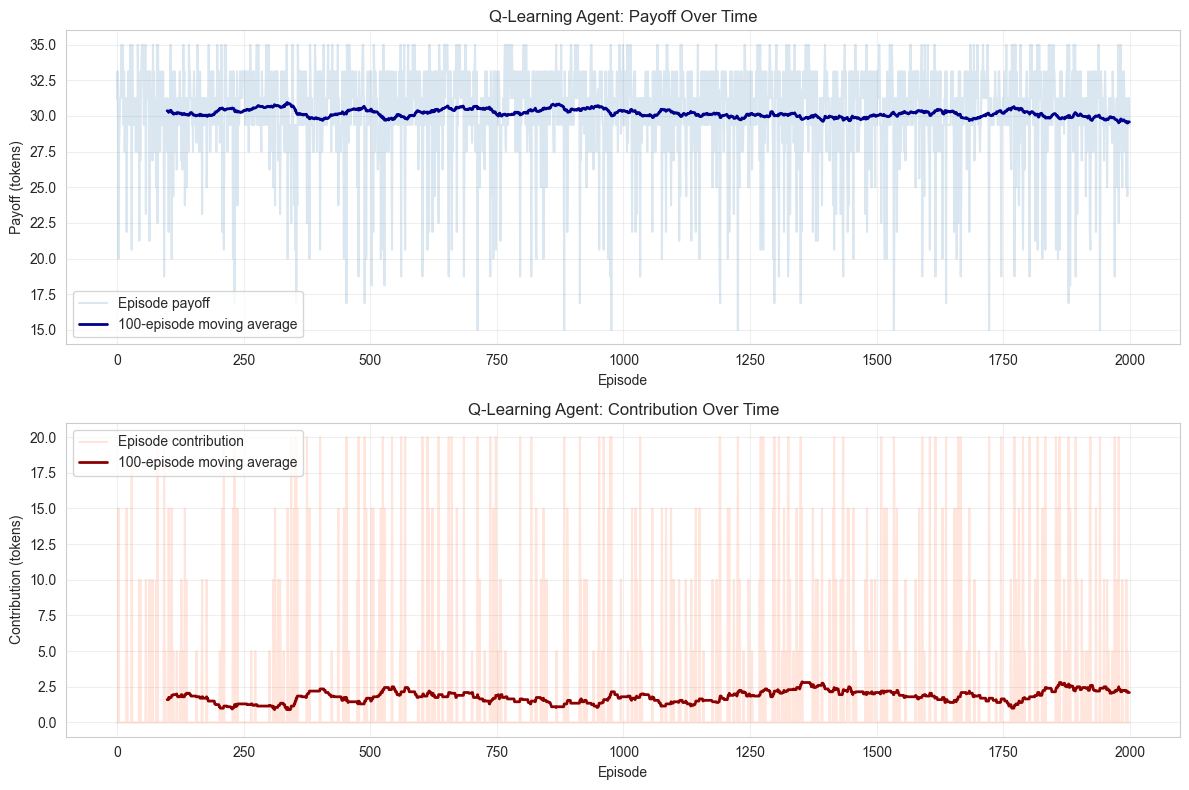

What patterns do you see?
Is the agent learning to cooperate or free-ride?


In [22]:
# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Payoffs over time
window = 100
moving_avg_payoff = np.convolve(payoffs, np.ones(window)/window, mode='valid')

axes[0].plot(payoffs, alpha=0.2, label='Episode payoff', color='steelblue')
axes[0].plot(range(window-1, len(payoffs)), moving_avg_payoff, 
             linewidth=2, label=f'{window}-episode moving average', color='darkblue')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Payoff (tokens)')
axes[0].set_title('Q-Learning Agent: Payoff Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Contributions over time
moving_avg_contrib = np.convolve(contributions_made, np.ones(window)/window, mode='valid')

axes[1].plot(contributions_made, alpha=0.2, label='Episode contribution', color='coral')
axes[1].plot(range(window-1, len(contributions_made)), moving_avg_contrib, 
             linewidth=2, label=f'{window}-episode moving average', color='darkred')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Contribution (tokens)')
axes[1].set_title('Q-Learning Agent: Contribution Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("What patterns do you see?")
print("Is the agent learning to cooperate or free-ride?")

## Step 9: Examine the Learned Q-Table

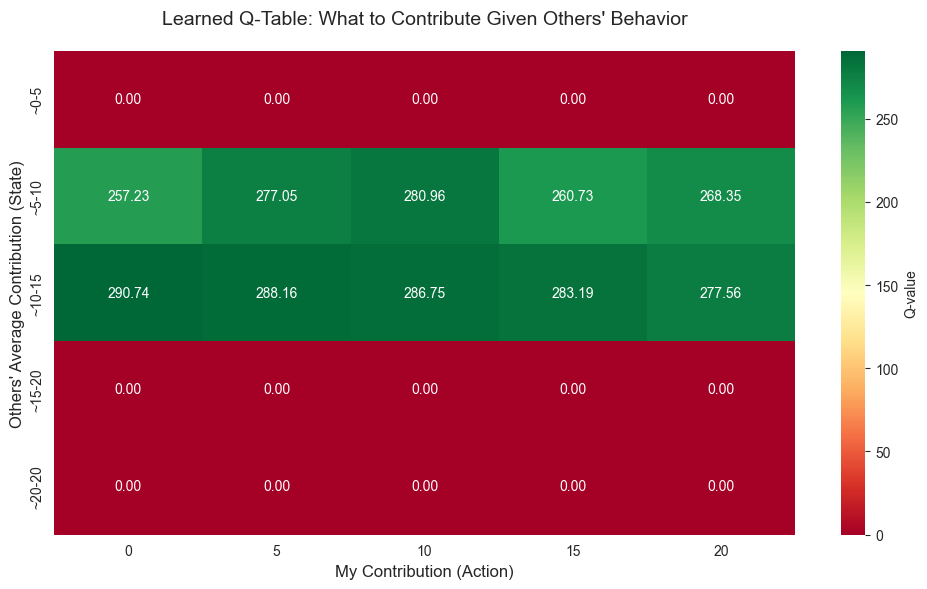

Reading the Q-table:
  - Each row is a STATE (what others are contributing on average)
  - Each column is an ACTION (what I could contribute)
  - Higher values (greener) mean better expected payoff
  - The agent has learned which contribution maximizes payoff in each situation!


In [11]:
# Display Q-table as a heatmap
plt.figure(figsize=(10, 6))

# Create labels
state_labels = [f'~{STATE_BINS[i]}-{STATE_BINS[i+1] if i < len(STATE_BINS)-1 else STATE_BINS[i]}' 
                for i in range(NUM_STATES)]
action_labels = [f'{c}' for c in POSSIBLE_CONTRIBUTIONS]

sns.heatmap(Q_table, annot=True, fmt='.2f', cmap='RdYlGn', 
            xticklabels=action_labels, yticklabels=state_labels,
            cbar_kws={'label': 'Q-value'})

plt.xlabel('My Contribution (Action)', fontsize=12)
plt.ylabel('Others\' Average Contribution (State)', fontsize=12)
plt.title('Learned Q-Table: What to Contribute Given Others\' Behavior', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("Reading the Q-table:")
print("  - Each row is a STATE (what others are contributing on average)")
print("  - Each column is an ACTION (what I could contribute)")
print("  - Higher values (greener) mean better expected payoff")
print("  - The agent has learned which contribution maximizes payoff in each situation!")

## Step 10: Extract and Visualize the Learned Policy

In [12]:
# Extract best action for each state
policy = np.argmax(Q_table, axis=1)
best_contributions = [POSSIBLE_CONTRIBUTIONS[i] for i in policy]

print("Learned Policy (greedy, no exploration):\n")
print("  Others' Avg    →    My Best Contribution")
print("  " + "="*45)
for i, state_label in enumerate(state_labels):
    print(f"  {state_label:15s} →    {best_contributions[i]:2d} tokens")

print()
print("Interpretation:")
if best_contributions[0] == 0 and best_contributions[-1] == 0:
    print("  The agent learned to FREE-RIDE (contribute 0) regardless of others' behavior.")
    print("  This maximizes individual payoff but leads to collective failure!")
elif best_contributions[0] < best_contributions[-1]:
    print("  The agent learned CONDITIONAL COOPERATION.")
    print("  It contributes more when others contribute more!")
elif all(c == max(POSSIBLE_CONTRIBUTIONS) for c in best_contributions):
    print("  The agent learned to COOPERATE fully, always contributing maximum.")
    print("  This is pro-social but might not maximize individual payoff.")
else:
    print("  The agent learned a mixed strategy based on others' behavior.")

Learned Policy (greedy, no exploration):

  Others' Avg    →    My Best Contribution
  ~0-5            →     0 tokens
  ~5-10           →    10 tokens
  ~10-15          →     0 tokens
  ~15-20          →     0 tokens
  ~20-20          →     0 tokens

Interpretation:
  The agent learned to FREE-RIDE (contribute 0) regardless of others' behavior.
  This maximizes individual payoff but leads to collective failure!


## Step 11: Visualize Policy as a Bar Chart

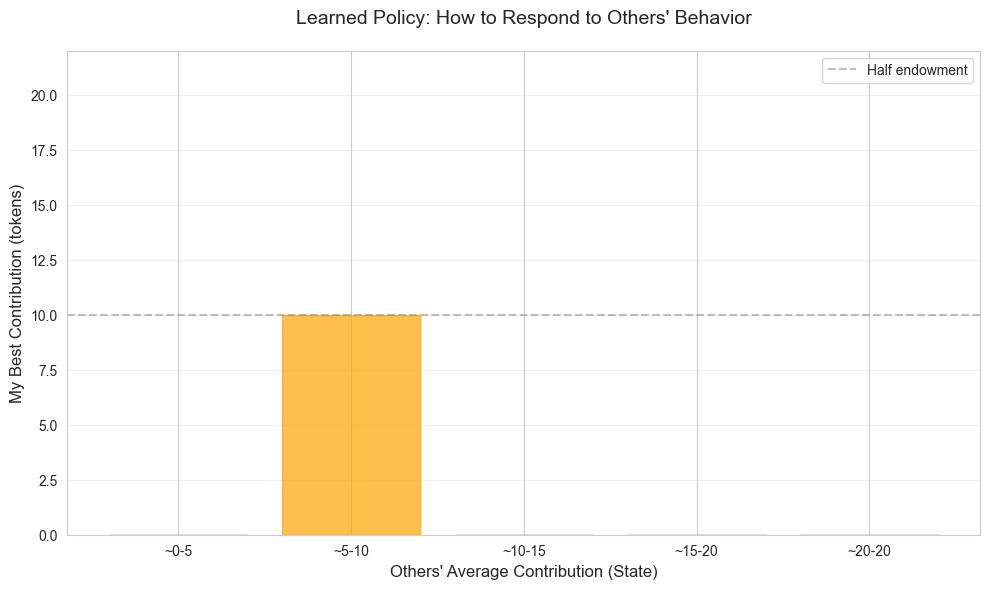

In [13]:
plt.figure(figsize=(10, 6))

x = np.arange(len(state_labels))
bars = plt.bar(x, best_contributions, color='steelblue', alpha=0.7, edgecolor='black')

# Color bars based on contribution level
colors = ['darkred' if c == 0 else 'orange' if c <= 10 else 'green' for c in best_contributions]
for bar, color in zip(bars, colors):
    bar.set_color(color)
    bar.set_alpha(0.7)

plt.xlabel('Others\' Average Contribution (State)', fontsize=12)
plt.ylabel('My Best Contribution (tokens)', fontsize=12)
plt.title('Learned Policy: How to Respond to Others\' Behavior', fontsize=14, pad=20)
plt.xticks(x, state_labels, rotation=0)
plt.ylim(0, ENDOWMENT + 2)
plt.grid(True, alpha=0.3, axis='y')

# Add reference line
plt.axhline(y=ENDOWMENT/2, color='gray', linestyle='--', alpha=0.5, label='Half endowment')
plt.legend()

plt.tight_layout()
plt.show()

## Step 12: Test Against Different Player Types

In [14]:
def test_policy_against_strategy(other_contributions, num_rounds=100):
    """
    Test the learned policy against a specific group strategy.
    """
    total_payoff = 0
    my_contributions = []
    
    for _ in range(num_rounds):
        # Get state
        avg_others = np.mean(other_contributions)
        state = get_state_from_avg_contribution(avg_others)
        
        # Choose best action (no exploration)
        action_idx = np.argmax(Q_table[state])
        my_contribution = POSSIBLE_CONTRIBUTIONS[action_idx]
        
        # Calculate payoff
        payoff = calculate_payoff(my_contribution, other_contributions)
        
        total_payoff += payoff
        my_contributions.append(my_contribution)
    
    return total_payoff / num_rounds, np.mean(my_contributions)

# Test against different group types
print("Testing learned policy against different group types:\n")

scenarios = [
    ("All cooperators", [20, 20, 20]),
    ("All free-riders", [0, 0, 0]),
    ("Mixed group", [0, 10, 20]),
    ("Moderate cooperators", [10, 10, 10]),
    ("High cooperators", [15, 15, 15]),
]

for scenario_name, others in scenarios:
    avg_payoff, avg_contrib = test_policy_against_strategy(others)
    print(f"{scenario_name}:")
    print(f"  Others contribute: {others} (avg: {np.mean(others):.1f})")
    print(f"  My average contribution: {avg_contrib:.2f} tokens")
    print(f"  My average payoff: {avg_payoff:.2f} tokens")
    print()

Testing learned policy against different group types:

All cooperators:
  Others contribute: [20, 20, 20] (avg: 20.0)
  My average contribution: 0.00 tokens
  My average payoff: 42.50 tokens

All free-riders:
  Others contribute: [0, 0, 0] (avg: 0.0)
  My average contribution: 0.00 tokens
  My average payoff: 20.00 tokens

Mixed group:
  Others contribute: [0, 10, 20] (avg: 10.0)
  My average contribution: 0.00 tokens
  My average payoff: 31.25 tokens

Moderate cooperators:
  Others contribute: [10, 10, 10] (avg: 10.0)
  My average contribution: 0.00 tokens
  My average payoff: 31.25 tokens

High cooperators:
  Others contribute: [15, 15, 15] (avg: 15.0)
  My average contribution: 0.00 tokens
  My average payoff: 36.88 tokens



## Discussion Questions

1. **What strategy did the Q-learning agent learn?**
   - Does it cooperate, free-ride, or conditionally cooperate?
   - Why do you think it learned this strategy?

2. **How does the agent respond to different group behaviors?**
   - Look at the policy: does contribution change based on others' contributions?
   - Is this rational from an individual payoff perspective?

3. **The social dilemma:**
   - What happens if everyone uses the same Q-learning strategy?
   - Would this lead to high or low group welfare?

4. **Parameters matter:**
   - What if we increase the MULTIPLIER to 2.0? Would cooperation increase?
   - What if we change the learning rate (alpha) or discount factor (gamma)?

5. **Reward structure:**
   - Currently, the reward is individual payoff. What if we added a group welfare component?
   - How might this change the learned behavior?

## Experiments to Try

1. **Change the multiplier** to 2.0 and retrain. Does the agent cooperate more?
2. **Modify the reward function** to include group welfare: `reward = my_payoff + 0.1 * total_group_payoff`
3. **Change epsilon** to 0.5 (more exploration) - how does this affect learning?
4. **Add punishment**: Deduct tokens if contribution is much lower than others
5. **Make other players also Q-learners**: What happens when all players learn simultaneously?

## Summary

### What We Learned

1. **Q-learning can learn social strategies** without being explicitly programmed
2. **States** represented others' average contributions (social context)
3. **Actions** were the agent's contribution choices
4. **Rewards** came from the game's payoff structure
5. **The learned policy** shows how the agent responds to different social situations

### Key Insight

Q-learning finds strategies that **maximize individual reward** given the environment. In social dilemmas:
- This often means free-riding (if others cooperate)
- But conditional cooperation can emerge if it's rewarded
- The learned behavior depends heavily on: game parameters, other players' strategies, and reward structure

### Real-World Applications

This framework can model:
- Climate change contributions
- Tax compliance
- Community resource management
- Teamwork and effort in groups
- Social norm emergence